# Setup

In [1]:
%matplotlib inline

In [1]:
import numpy as np
import pylab as plt
import pandas as pd
from scipy.interpolate import interp1d
from matplotlib.colors import LogNorm
# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from getpass import getpass

In [2]:
# here we can use the 'anonymous' user name, and an empty password
# token = ac.login('anonymous')

# To save to virtual space, need to log in your account (not anonymous)
token = ac.login(input('Enter user name (+ENTER): '),getpass('Enter password (+ENTER): '))  

Enter user name (+ENTER): zilishen
Enter password (+ENTER): ········


In [3]:
# Adding this notebook to vos public storage
sc.put(fr='./Isochrones_read_parsec.ipynb',to='vos://public/des/')

(1 / 1) ./Isochrones_read_parsec.ipynb -> vos://public/des/Isochrones_read_parsec.ipynb


'OK'

In [ ]:
#Retrieving the latest notebook to your current directory
sc.get (fr = 'zilishen://public/des/Isochrones_read_parsec.ipynb', to = './Isochrones_read_parsec.ipynb')
sc.get (fr='zilishen://public/des/parsec_5e7_1e9_1e8.dat', to = './parsec_5e7_1e9_1e8.dat')

# Begin

In [6]:
# Calculate max distance modulus = 2Mpc
# m − M = −5 + 5 log10 d
max_dist_modulus = -5 + 5*np.log10(2*10**6)   # farthest search 2 Mpc
min_dist_modulus = -5 + 5*np.log10(400*10**3) # closest search is 400 kpc
print(max_dist_modulus, min_dist_modulus)

26.505149978319906 23.010299956639813


In [7]:
def plot_iso(band_1, mag_1, band_2, mag_2, z, color = 'k', distance_modulus = 25, max_phot = 26):
    plt.scatter(mag_1-mag_2,mag_1+distance_modulus,marker='o',c=color)
    plt.gca().invert_yaxis()
    plt.ylim(max_phot,np.amin(mag_1+distance_modulus)-1)
    plt.xlabel('%s - %s'%(band_1,band_2)); plt.ylabel(band_1)
    plt.title('Metallicity z = %s'%z)

In [20]:
df = pd.read_csv('parsec_5e7_1e9_1e8.dat',skipinitialspace=True,delim_whitespace=True,comment='#')
### I removed the '#' in front of the first header row in the .dat file, so that pandas will not ignore it
df.head()

,Zini,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,...,Xo,Cexcess,Z,mbolmag,umag,gmag,rmag,imag,zmag,Ymag
0,0.000155,7.699,0.093638,1.115652,0.094,-2.298,3.5702,4.940,0,0.0,...,0.000072,-1.0,0.000164,10.516,14.583,12.345,10.895,10.345,10.069,9.968
1,0.000155,7.699,0.094257,1.121257,0.094,-2.294,3.5706,4.941,0,0.0,...,0.000072,-1.0,0.000164,10.506,14.565,12.331,10.883,10.334,10.059,9.958
2,0.000155,7.699,0.099841,1.169777,0.100,-2.256,3.5744,4.941,0,0.0,...,0.000072,-1.0,0.000164,10.409,14.399,12.199,10.767,10.230,9.957,9.857
3,0.000155,7.699,0.103573,1.200278,0.103,-2.231,3.5771,4.943,0,0.0,...,0.000072,-1.0,0.000164,10.347,14.287,12.112,10.691,10.163,9.891,9.792
4,0.000155,7.699,0.112781,1.269788,0.113,-2.174,3.5821,4.944,0,0.0,...,0.000072,-1.0,0.000164,10.206,14.054,11.923,10.525,10.012,9.742,9.644


In [21]:
df.columns

Index(['Zini', 'logAge', 'Mini', 'int_IMF', 'Mass', 'logL', 'logTe', 'logg',
       'label', 'McoreTP', 'C_O', 'period0', 'period1', 'pmode', 'Mloss',
       'tau1m', 'X', 'Y', 'Xc', 'Xn', 'Xo', 'Cexcess', 'Z', 'mbolmag', 'umag',
       'gmag', 'rmag', 'imag', 'zmag', 'Ymag'],
      dtype='object')

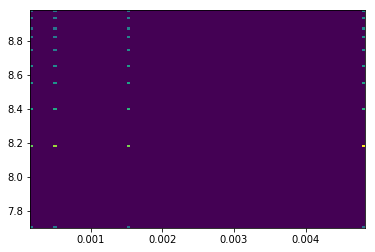

In [22]:
h = plt.hist2d(df['Zini'],df['logAge'],bins=100) # see the distribution of z and age

In [23]:
# Looks like we have a pretty regular grid of ages and z, as expected.
# Each isochrone should have the same z and same age, so let's find all of them
all_z = np.unique(df['Zini'])
all_age = np.unique(df['logAge'])

# G - I mag as color

(300, 30)


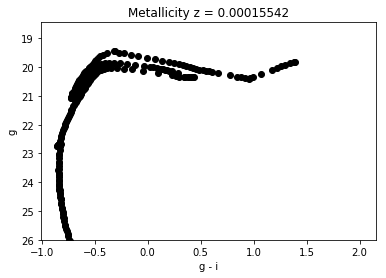

In [25]:
# As a test, we read in the first isochrone
iso_z1 = df.loc[df.loc[:,'Zini'] == all_z[0],:] # iso_z1 all have the same Zini = 0.000155
iso1 = iso_z1.loc[iso_z1.loc[:,'logAge'] == all_age[0],:]
g_mag = iso1['gmag']
i_mag = iso1['imag']
print(iso1.shape)
plot_iso('g',g_mag,'i',i_mag,iso1.loc[0,'Zini'])

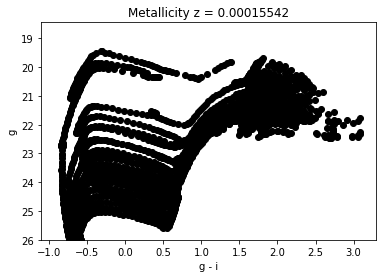

In [26]:
# Now we plot all the isochrones with the first metallicity 0.000155
plot_iso('g',iso_z1['gmag'],'i',iso_z1['imag'],iso_z1.loc[0,'Zini'])

Text(0.5,1,'Min distance modulus = 23.010299956639813')

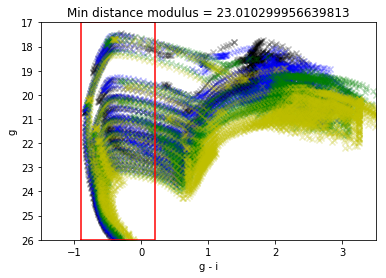

In [35]:
# Now we want to know how much the isochrone shifts with changing z
# so we plot all of them, with colors indicating metallicity
distance_modulus = min_dist_modulus
max_phot = 26
colors = ['k','b','g','y']
coord = [[-0.9,26], [-0.9,17],[0.2,17], [0.2,26]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

for i in np.arange(len(all_z)):
    z = all_z[i]
    iso = df.loc[df.loc[:,'Zini'] == z,:]
    plt.scatter(iso['gmag']-iso['imag'], iso['gmag']+distance_modulus,marker='x',c=colors[i],alpha=0.25)
plt.gca().invert_yaxis()
plt.plot(xs,ys,c='r')
plt.ylim(max_phot,17)
plt.xlim(-1.5,3.5)
plt.xlabel('g - i'); plt.ylabel('g')
plt.title('Min distance modulus = %s'%min_dist_modulus)

Text(0.5,1,'Parsec isochrones')

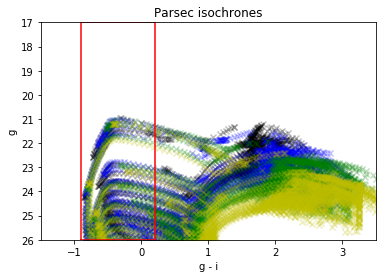

In [33]:
# Now we want to know how much the isochrone shifts with changing z
# so we plot all of them, with colors indicating metallicity
distance_modulus = max_dist_modulus
max_phot = 26
colors = ['k','b','g','y']
coord = [[-0.9,26], [-0.9,17],[0.2,17], [0.2,26]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

for i in np.arange(len(all_z)):
    z = all_z[i]
    iso = df.loc[df.loc[:,'Zini'] == z,:]
    plt.scatter(iso['gmag']-iso['imag'], iso['gmag']+distance_modulus,marker='x',c=colors[i],alpha=0.25)
plt.gca().invert_yaxis()
plt.plot(xs,ys,c='r')
plt.ylim(max_phot,17)
plt.xlim(-1.5,3.5)
plt.xlabel('g - i'); plt.ylabel('g')
plt.title('Parsec isochrones')

# Compare G - Z color to G - I color

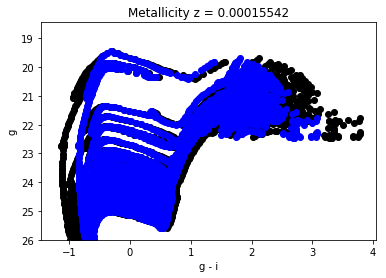

In [28]:
plot_iso('g',iso_z1['gmag'],'z',iso_z1['zmag'],iso_z1.loc[0,'Zini'])
plot_iso('g',iso_z1['gmag'],'i',iso_z1['imag'],iso_z1.loc[0,'Zini'],color='b') # g - i is in blue

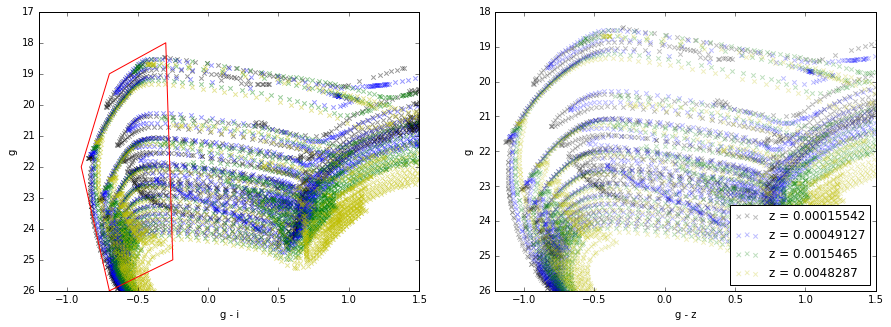

In [141]:
distance_modulus = 24
max_phot = 26
colors = ['k','b','g','y']
x_min = -1.2
x_max = 1.5
plt.figure(figsize=(15,5))

plt.subplot(121)
coord = [[-0.7,26], [-0.9,22],[-0.7,19],[-0.3,18], [-0.25,25]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

for i in np.arange(len(all_z)):
    z = all_z[i]
    iso = df.loc[df.loc[:,'Zini'] == z,:]
    plt.scatter(iso['gmag']-iso['imag'], iso['gmag']+distance_modulus,
                marker='x',c=colors[i],alpha=0.4)
plt.gca().invert_yaxis()
plt.ylim(max_phot,17)
plt.xlim(x_min,x_max)
plt.xlabel('g - i'); plt.ylabel('g')
plt.plot(xs,ys,c='r')

plt.subplot(122)
for i in np.arange(len(all_z)):
    z = all_z[i]
    iso = df.loc[df.loc[:,'Zini'] == z,:]
    plt.scatter(iso['gmag']-iso['zmag'], iso['gmag']+distance_modulus,
                marker='x',c=colors[i],alpha=0.25,label = 'z = %s'%z)
plt.gca().invert_yaxis()
plt.ylim(max_phot,18)
plt.xlim(x_min,x_max)
plt.xlabel('g - z'); plt.ylabel('g')
plt.legend(loc=4)

plt.savefig('parsec_iso.png')